In [1]:
import statistics
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scripts import strip_detection

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
test_files = [
               'VHF/dilution1',
               'VHF/dilution2',    
               'VHF/dilution3',
               'VHF/dilution4',
               'VHF/dilution5',
               'VHF/dilution6',
             ]

# test_files = ['tickborne/Ana_DNA_LF',
#               'tickborne/Ana_FTA_LF',
#               'tickborne/Bab_DNA_LF',
#               'tickborne/Bab_FTA_LF']

# test_files = ['SL-IV-1',
#               'EBOV-1-G2']

# #               'EBOV-2-G9', # too dark
# #              'SL-LOD-1.jpg', # too dark
              
#               'LF-1-patients',
#               'N2-LOD-1',
#               'N2-LOD-2',
#               'N2-LOD-3',
#               'NG-LOD-1']

LODStandardDeviation = 31

In [3]:
# Some utilities

def makeOrderedBox(rect):
    """
    Return a 4-element tuple representing the corners of a box:
        idx 0 = top left corner   
        idx 1 = top right corner 
        idx 2 = bottom right corner
        idx 3 = botton left corner
    """
    box0 = cv2.boxPoints(rect)
    box0 = np.int0(box0)
    
    xval = [pt[0] for pt in box0]
    yval = [pt[1] for pt in box0]
    
    x0 = np.mean(xval)
    y0 = np.mean(yval)
  
    angles = []
    for i in range(0, len(box0)):
        xi = box0[i][0]
        yi = box0[i][1]        
        x = xi - x0
        y = yi - y0
        a = np.arctan2(y, x)
        val = [a, i]
        angles += [val]

    angles.sort(key=lambda val: val[0], reverse=False)    
    box = np.array([box0[val[1]] for val in angles])
    
    return box

def boxMinX(box):
    return min([pt[0] for pt in box])

def boxMaxX(box):  
    return max([pt[0] for pt in box])

def boxMinY(box):
    return min([pt[1] for pt in box])

def boxMaxY(box):
    return max([pt[1] for pt in box])

def boxArea(box):
    x0 = np.mean([pt[0] for pt in box])
    y0 = np.mean([pt[1] for pt in box])
    p0 = np.array([x0, y0])
    
    area = 0
    n = len(box)
    for i in range(0, n):
        p1 = box[i]
        if i < n - 1:
            p2 = box[i + 1]
        else:
            p2 = box[0]
            
        # Heron's Formula
        a = np.linalg.norm(p1-p0)
        b = np.linalg.norm(p2-p0)
        c = np.linalg.norm(p1-p2)
        s = (a + b + c) / 2
        triarea = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        area += triarea        
        
    return area

def rectArea(rect):
    return rect[1][0]*rect[1][1]

def pointDistance(p1, p2):
    """
    Given two poiints, each represented by a tuple (x1, y1), calculate the eucalidian distance
    between them.
    """
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def boxesIntersection(box1, box2, img_shape):
    # Calculate the total intersection area of two boxes:
    
    # first sort the points in the boxes as (x,y) in descending order:
    box1.sort()
    box2.sort()
    
    blanked_image = np.zeros( shape = (img_shape[0], img_shape[1], 1), dtype = "uint8")
    cv2.drawContours(blanked_image, [box], 0, (255, 255, 255), thickness = -1)
    cv2.drawContours(blanked_image, [box], 0, (255, 255, 255), thickness = -1)
    
    return cv2.countNonZero(blanked_image)

def applyClahetoRGB(bgr_imb):
    
    lab= cv2.cvtColor(bgr_imb, cv2.COLOR_BGR2LAB)
    # Split lab image to different channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    
    #Convert image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def intersectLines(pt1, pt2, ptA, ptB): 
    """ this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)
        https://www.cs.hmc.edu/ACM/lectures/intersections.html    
        
        returns a tuple: (xi, yi, valid, r, s), where
        (xi, yi) is the intersection
        r is the scalar multiple such that (xi,yi) = pt1 + r*(pt2-pt1)
        s is the scalar multiple such that (xi,yi) = pt1 + s*(ptB-ptA)
            valid == 0 if there are 0 or inf. intersections (invalid)
            valid == 1 if it has a unique intersection ON the segment    """

    DET_TOLERANCE = 0.00000001

    # the first line is pt1 + r*(pt2-pt1)
    # in component form:
    x1, y1 = pt1;   x2, y2 = pt2
    dx1 = x2 - x1;  dy1 = y2 - y1

    # the second line is ptA + s*(ptB-ptA)
    x, y = ptA;   xB, yB = ptB;
    dx = xB - x;  dy = yB - y;

    # we need to find the (typically unique) values of r and s
    # that will satisfy
    #
    # (x1, y1) + r(dx1, dy1) = (x, y) + s(dx, dy)
    #
    # which is the same as
    #
    #    [ dx1  -dx ][ r ] = [ x-x1 ]
    #    [ dy1  -dy ][ s ] = [ y-y1 ]
    #
    # whose solution is
    #
    #    [ r ] = _1_  [  -dy   dx ] [ x-x1 ]
    #    [ s ] = DET  [ -dy1  dx1 ] [ y-y1 ]
    #
    # where DET = (-dx1 * dy + dy1 * dx)
    #
    # if DET is too small, they're parallel
    #
    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0,0,0,0,0)

    # now, the determinant should be OK
    DETinv = 1.0/DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy  * (x-x1) +  dx * (y-y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x-x1) + dx1 * (y-y1))

    # return the average of the two descriptions
    xi = (x1 + r*dx1 + x + s*dx)/2.0
    yi = (y1 + r*dy1 + y + s*dy)/2.0
    return ( xi, yi, 1, r, s )

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False
    
def rotate_image(img, center, angle, width, height):

   shape = (img.shape[1], img.shape[0]) # (length, height)

   matrix = cv2.getRotationMatrix2D((center[0], center[1]), angle, 1 )
   rotated = cv2.warpAffine( img, matrix, shape )

   x = int( center[0] - width/2  )
   y = int( center[1] - height/2 )

   cropped = rotated[ y:y+height, x:x+width ]

   return cropped

def getTruthValueFromFile(filename):
    if filename is None:
        return []
    truth_values = []
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line != 'pos' and line != 'neg':
                raise Exception('Truth file contains line other than "pos" or "neg"')
            if line == 'pos':                    
                truth_values.append(1)
            else:
                truth_values.append(0)
    return truth_values

def score_confidence_interval(score_fun, y_true, y_pred, pvalue, niter):
    """
    Calculation of the confidence interval for a given p-value using bootstrap sampling
    http://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
    """
    
    n_bootstraps = niter
    bootstrapped_scores = []
    
#     rng_seed = 42  # control reproducibility
#     rng = np.random.RandomState(rng_seed)

    rng = np.random.RandomState()
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))
        
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = score_fun(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int((1 - pvalue) * len(sorted_scores))] 
    confidence_upper = sorted_scores[int(pvalue * len(sorted_scores))]

    return [confidence_lower, confidence_upper]

def auc_confidence_interval(y_true, y_pred, pvalue=0.95, niter=1000):
    return score_confidence_interval(roc_auc_score, y_true, y_pred, pvalue, niter)

def getStripPixelAreaFromFile(filename):
    if filename is None:
        return None
    with open(filename) as file:
        for line in file:
            return int(line)

In [4]:
all_scores = []
all_truths = []
for test in test_files:
    img_fn = 'images/' + test + ".jpg"
    tru_fn = 'images/' + test + ".txt"

    t = getTruthValueFromFile(tru_fn)
    s, _ = strip_detection.getPredictions(img_fn, getStripPixelAreaFromFile('images/' + test + '_size.txt') )
    all_scores += s
    all_truths += t[:-1]
    print(img_fn)
    print(t)
    print(s)

images/VHF/dilution1.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 1, 0.503984674329502]
images/VHF/dilution2.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 0.6301647509578542, 0.4722001915708812, 0.5571197318007667, 0.6455421455938701]
images/VHF/dilution3.jpg
[1, 1, 1, 1, 0, 0]
[1, 1, 1, 0.2924128352490424, 0.44383141762452083]
images/VHF/dilution4.jpg
[1, 1, 1, 0, 0]
[1, 1, 1, 0.7946149425287353]
images/VHF/dilution5.jpg
[1, 1, 1, 1, 1, 0, 0]
[1, 0.6999166666666667, 0.607787356321839, 0.5383314176245213, 0.5776551724137935, 0.6399559386973183]
images/VHF/dilution6.jpg
[1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 0.7295459770114945, 0.5627586206896554, 0.41427107279693487]


In [7]:
class_threshold = 0.8
p_value = 0.95
all_preds = np.array([int(class_threshold < p) for p in all_scores])

ytrue = np.array(all_truths)
probs = np.array(all_scores)
ypred = all_preds

auc = roc_auc_score(ytrue, probs)
fpr, tpr, thresholds = roc_curve(ytrue, probs) 
brier = brier_score_loss(ytrue, probs)
# cal, dis = caldis(ytrue, probs)
acc = accuracy_score(ytrue, ypred)
precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

auc_ci = auc_confidence_interval(ytrue, probs, p_value)

P = N = 0
TP = TN = 0
FP = FN = 0
for i in range(len(ytrue)):
    if ytrue[i] == 1:
        P += 1
        if ypred[i] == 1: TP += 1
        else: FN += 1
    else:
        N += 1
        if ypred[i] == 0: TN += 1
        else: FP += 1
            
sens = float(TP)/P
spec = float(TN)/N

# Positive and Negative Predictive Values
# https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values
ppv = float(TP) / (TP + FP)
npv = float(TN) / (TN + FN)
        
# Likelihood ratios
# https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing
lr_pos = sens / (1 - spec) if spec < 1 else np.inf
lr_neg = (1 - sens) / spec if 0 < spec else np.inf

# print "True outcomes:", ytrue
# print "Prediction   :", ypred
cfr = 100 * (float(np.sum(ytrue)) / len(ytrue))
print("Number of strips   :", len(ytrue))
print("Number of positives:", np.sum(ytrue)) 
print("Perc. of positives : %0.2f" % cfr)

print("")
print("Measures of performance") 
print("AUC           : %0.2f (%0.2f, %0.2f)" % (auc, auc_ci[0], auc_ci[1])) 
print("Brier         : %0.2f" % brier) 
# print("Calibration   :", cal) 
# print("Discrimination:", dis) 
print("Accuracy      : %0.2f" % acc) 
print("Sensitivity   : %0.2f" % sens) 
print("Specificity   : %0.2f" % spec) 
# print("PPV           : %0.2f" % ppv) 
# print("NPV           : %0.2f" % npv) 

Number of strips   : 34
Number of positives: 29
Perc. of positives : 85.29

Measures of performance
AUC           : 0.77 (0.62, 0.92)
Brier         : 0.13
Accuracy      : 0.68
Sensitivity   : 0.62
Specificity   : 1.00


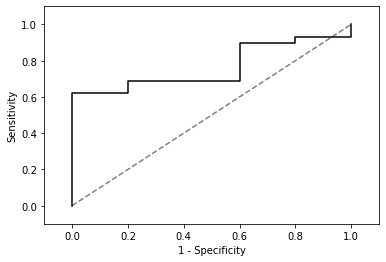

In [8]:
fig, ax = plt.subplots()
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.plot(fpr, tpr, color='black')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
fig.savefig('reader-roc.pdf')